In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [ ]:
class Pair:
    def __init__(self, asset1, asset2, conversion=None):
        self.asset1 = asset1
        self.asset2 = asset2
        self.conversion = conversion

    def backtest(self, start_date, end_date, window, entry_threshold, exit_threshold, reverse=False, verbose=False):
        df = yf.download([self.asset1, self.asset2], start=start_date, end=end_date, auto_adjust=True, progress=False)["Close"]

        if (self.conversion is not None):
            rate = yf.download(self.conversion, start=start_date, end=end_date, auto_adjust=True, progress=False)["Close"]
            df [self.asset1] *= rate[self.conversion]
            
        df["ratio"] = df[self.asset1] / df[self.asset2]

        if (reverse):
            df.loc[:, :] = df.iloc[::-1].values

        df.dropna(inplace=True)
        df["ratio_ma"] = df["ratio"].rolling(window=window).mean()
        df["ratio_std"] = df["ratio"].rolling(window=window).std()
        df["z_score"] = (df["ratio"] - df["ratio_ma"]) / df["ratio_std"]

        df[f"{self.asset1} return"] = df[self.asset1].pct_change()
        df[f"{self.asset2} return"] = df[self.asset2].pct_change()

        df.dropna(inplace=True)

        positions = pd.DataFrame(0, index=df.index, columns=[self.asset1, self.asset2])
        current_position = 0  # 0 for no position, 1 for long-short, -1 for short-long

        # Trading logic based on ratio
        for i in range(len(df)):
            if current_position == 0:
                if df["z_score"].iloc[i] > entry_threshold:
                    positions.iloc[i] = [-1, 1]  # Short etf1, Long etf2
                    current_position = 1
                elif df["z_score"].iloc[i] < -entry_threshold:
                    positions.iloc[i] = [1, -1]  # Long etf1, Short etf2
                    current_position = -1
            else:
                if abs(df["z_score"].iloc[i]) < exit_threshold:
                    positions.iloc[i] = [0, 0]
                    current_position = 0
                else:
                    positions.iloc[i] = positions.iloc[i-1]

        # Shift positions by 1 day for backtesting
        positions = positions.shift(1)
        positions.fillna(0, inplace=True)

        returns = pd.DataFrame(index=df.index)
        returns[self.asset1] = positions[self.asset1] * df[f"{self.asset1} return"]
        returns[self.asset2] = positions[self.asset2] * df[f"{self.asset2} return"]
        returns["total"] = returns[self.asset1] + returns[self.asset2]

        portfolio_value = (1 + returns["total"]).cumprod()

        sharpe_ratio = np.sqrt(252) * returns["total"].mean() / returns["total"].std()
        max_drawdown = (portfolio_value / portfolio_value.cummax() - 1).min()

        adf_result = adfuller(df["ratio"].dropna())

        if (verbose):
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

            ax1.plot(df["ratio"])
            ax1.set_title(f"Price Ratio ({self.asset1}/{self.asset2})")
            ax1.grid(True)

            ax2.plot(df["z_score"])
            ax2.axhline(y=entry_threshold, color="r", linestyle="--")
            ax2.axhline(y=-entry_threshold, color="r", linestyle="--")
            ax2.axhline(y=0, color="black", linestyle="-")
            ax2.set_title("Z-Score of Ratio")
            ax2.grid(True)

            ax3.plot(positions[self.asset1], label=f"{self.asset1} position")
            ax3.plot(positions[self.asset2], label=f"{self.asset2} position")
            ax3.set_title("Positions")
            ax3.legend()
            ax3.grid(True)

            ax4.plot(portfolio_value)
            ax4.set_title("Portfolio Value")
            ax4.grid(True)

            plt.tight_layout()
            plt.show()

            print(f"ADF test p-value for ratio: {adf_result[1]}")
            print(f"Performance Metrics:")
            print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
            print(f"Maximum Drawdown: {max_drawdown:.2%}")
            print(f"Final Portfolio Value: {portfolio_value.iloc[-1]:.4f}")

            trade_changes = (positions != positions.shift(1)).any(axis=1)
            num_trades = trade_changes.sum() / 2
            print(f"\nNumber of trades: {num_trades:.0f}")
            print(f"Average holding period: {len(df)/num_trades:.1f} days")

            print("\nPosition Statistics:")
            print(f"Days with positions: {(positions != 0).any(axis=1).sum()}")
            print(f"Days with no positions: {(positions == 0).all(axis=1).sum()}")

        return [portfolio_value.iloc[-1], sharpe_ratio, max_drawdown]

In [38]:
# IBIT, ARKB, BITB, GBTC, FBTC, BTC
pair1 = Pair(asset1="BTC-EUR", asset2="BTC-USD", conversion="EURUSD=X")

Ticker,BTC-EUR,BTC-USD,ratio
Date,,,
2024-02-21,52300.368519,51839.179688,1.008897
2024-02-22,51839.460754,51304.972656,1.010418
2024-02-23,51305.307393,50731.949219,1.011302
2024-02-24,NaN,51571.101562,NaN
2024-02-25,NaN,51733.238281,NaN
2024-02-26,51739.055661,54522.402344,0.948950
2024-02-27,54525.597949,57085.371094,0.955159
2024-02-28,57104.378553,62504.789062,0.913600
2024-02-29,62506.618748,61198.382812,1.021377


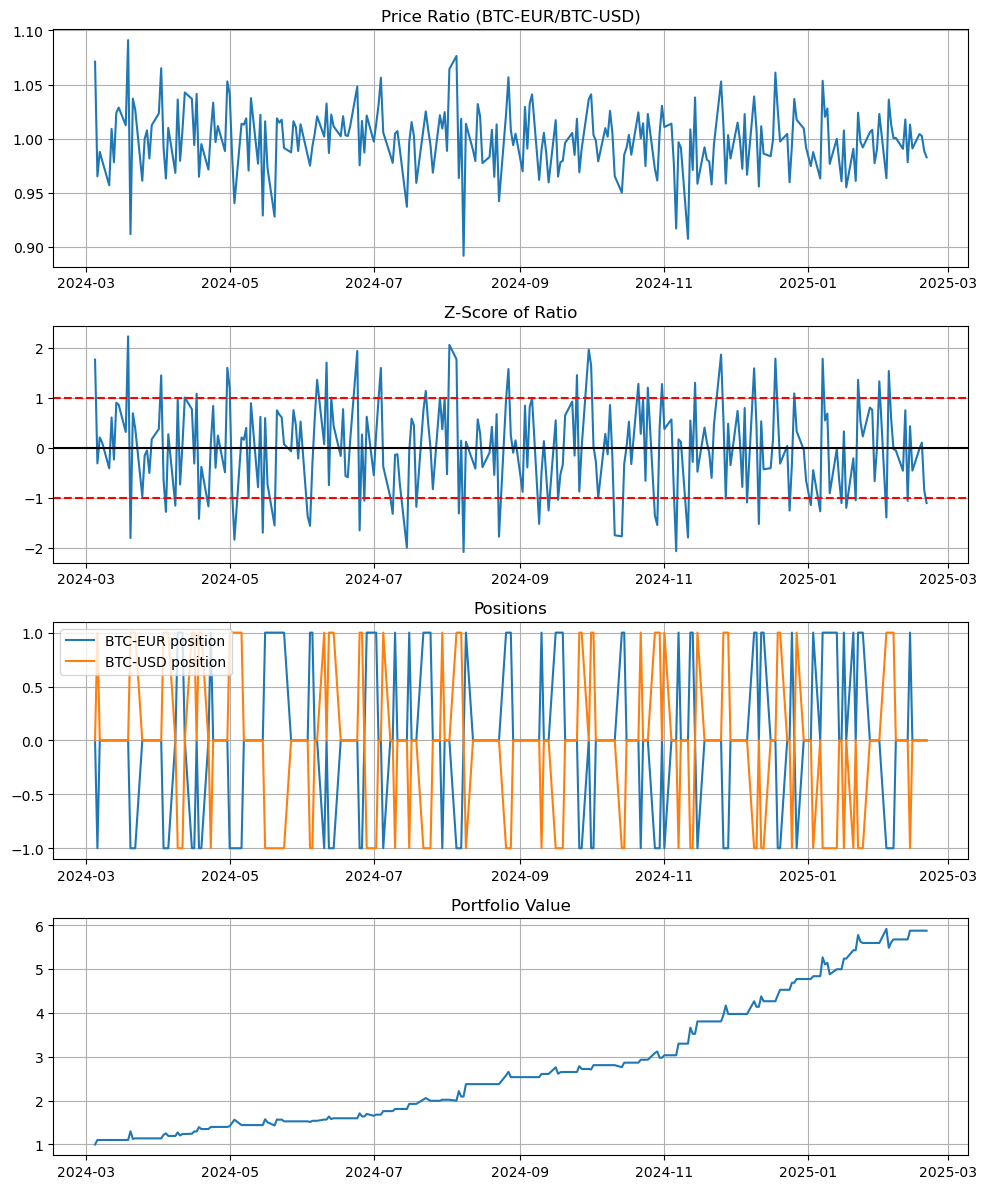

ADF test p-value for ratio: 3.908929952212828e-30
Performance Metrics:
Sharpe Ratio: 3.65
Maximum Drawdown: -13.24%
Final Portfolio Value: 5.8725

Number of trades: 46
Average holding period: 5.4 days

Position Statistics:
Days with positions: 99
Days with no positions: 153


In [40]:
pair1.backtest(start_date="2024-02-21", end_date="2025-02-21", window=10, entry_threshold=1, exit_threshold=0.5, verbose=True, reverse=False);

Notes:

Reverse dataset to test on bearish market

Implement adaptive parameters - have another larger rolling window to change parameters on the fly

In [ ]:
results = pd.DataFrame(columns=["window", "entry_threshold", "exit_threshold", "total_return", "sharpe_ratio", "max_drawdown"])

for window in [5, 7, 10, 15]:
    for entry_threshold in [0.5, 1, 1.2]:
        for exit_threshold in [0.3, 0.5, 1]:
            result = pair1.backtest(
                start_date="2024-2-21", 
                end_date="2025-02-21", 
                window=window, 
                entry_threshold=entry_threshold, 
                exit_threshold=exit_threshold,
                verbose=False
            )
            results.loc[len(results)] = [window, entry_threshold, exit_threshold, *result]

results

,window,entry_threshold,exit_threshold,total_return,sharpe_ratio,max_drawdown
0,5.0,0.5,0.3,2.555207,1.705563,-0.130221
1,5.0,0.5,0.5,4.578202,2.664914,-0.125015
2,5.0,0.5,1.0,8.989007,3.958596,-0.125015
3,5.0,1.0,0.3,2.867042,1.921409,-0.160560
4,5.0,1.0,0.5,5.255880,3.103101,-0.162947
5,5.0,1.0,1.0,8.671673,4.312867,-0.162947
6,5.0,1.2,0.3,2.732732,1.976190,-0.125649
7,5.0,1.2,0.5,4.804189,3.387232,-0.125015
8,5.0,1.2,1.0,5.563851,3.859272,-0.125015
9,7.0,0.5,0.3,2.699441,1.827683,-0.179397
